In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd

In [3]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing
import numpy as np

In [4]:
data = pd.read_csv("X_train.csv")

In [5]:
answers = pd.read_csv("y_train.csv")

In [6]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [7]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [8]:
data.head()

,age,gender,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,...,v6_4991,v6_4992,v6_4993,v6_4994,v6_4995,v6_4996,v6_4997,v6_4998,v6_4999,axis_id
0,0.192357,1,-59.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,...,114.0,119.0,124.0,129.0,134.0,147.0,172.0,200.0,143.0,3
1,1.399105,0,-39.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,...,229.0,259.0,289.0,319.0,349.0,379.0,409.0,439.0,302.0,3
2,0.137505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-38.0,-11.0,-2.0,2
3,1.344253,0,108.0,106.0,93.0,79.0,86.0,74.0,64.0,51.0,...,81.0,89.0,79.0,59.0,61.0,64.0,49.0,26.0,10.0,3
4,-1.453208,1,363.0,366.0,366.0,353.0,334.0,314.0,306.0,294.0,...,-61.0,-59.0,-86.0,-66.0,-71.0,-91.0,-84.0,-11.0,-4.0,0


In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [11]:
from basics import *

In [12]:
class ECGDataset(FilteredDataset):
    def __init__(self, data, signal_length, low_cut = 5, high_cut = 20):
        super().__init__(data, low_cut, high_cut)
        self.signal_length = signal_length
        used_data = self.filtered_data
        used_data = [np.array(row) for row in used_data.copy()]
        used_data = np.array(used_data)
        self.values = (used_data - used_data.mean())/used_data.std()


    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        label = self._get_label(idx)
        cut_point = 0 if self.signal_length >= 5000 else np.random.randint(5001 - self.signal_length)
        signals = self.values[idx][:, cut_point:cut_point+self.signal_length]
        
        return signals, label, self.data[idx][-1]

In [13]:
valid_size = 0.1

num_train = len(data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(7)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_dataset = ECGDataset(data.iloc[train_idx], 2000)
valid_dataset = ECGDataset(data.iloc[valid_idx],  2000)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [14]:
batchsize = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = True
)

In [15]:
import torch.nn as nn

In [16]:
ecg, labels, labels_idx = train_dataset[0]
ecg = torch.tensor([ecg]).float()

In [17]:
labels_idx

1.0

In [18]:
avg_pool = nn.AvgPool1d(10)

In [19]:
evg_ecg = avg_pool(ecg)

In [20]:
evg_ecg.shape

torch.Size([1, 12, 200])

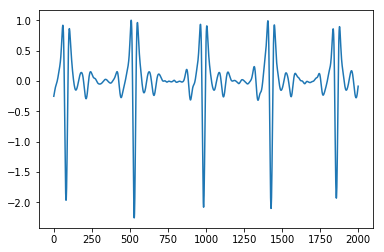

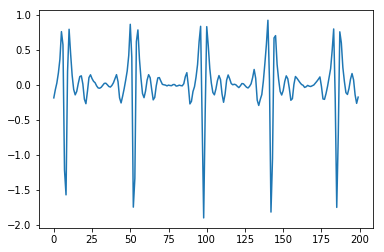

In [21]:
plt.plot(ecg[0][6].cpu().numpy())
plt.show()
plt.plot(evg_ecg.detach()[0][6].cpu().numpy())
plt.show()


In [22]:
class CNN1d(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN1d, self).__init__()
        #[batch size, channels_12, 3000]
        self.reduce_layer = nn.AvgPool1d(5)
        #[batch size, channels_12, 300]
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(12, 128, kernel_size=9, padding = 4), 
            nn.BatchNorm1d(128),
            nn.ReLU(), 
            nn.Conv1d(128, 128, kernel_size=5, padding = 2), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(128),
            nn.Dropout(dropout)
        ) 
        
        self.shortcut1 =  nn.Sequential(
            nn.Conv1d(12, 128, kernel_size=1),
            nn.BatchNorm1d(128)
        )
        self.sum_relu1 = nn.ReLU()
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=9, padding = 4), 
            nn.BatchNorm1d(256),
            nn.ReLU(), 
            nn.Conv1d(256, 256, kernel_size=5, padding = 2), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.Dropout(dropout)
        ) 
        
        self.shortcut2 =  nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1),
            nn.BatchNorm1d(256)
        )
        
        self.sum_relu2 = nn.ReLU()
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=9, padding = 4), 
            nn.BatchNorm1d(256),
            nn.ReLU(), 
            nn.Conv1d(256, 256, kernel_size=5, padding = 2), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding = 1), 
            nn.BatchNorm1d(256),
            nn.Dropout(dropout)
        ) 
        
        self.shortcut3 =  nn.Sequential(
            nn.BatchNorm1d(256)
        )
        self.sum_relu3 = nn.ReLU()
        
        self.time_avg = nn.AvgPool1d(400)
       
        self.fc = nn.Linear(256, 4)
        self.sm = nn.Softmax(dim = 1)
        
    def forward(self, x):
        identity = self.reduce_layer(x)
        
        out = self.layer1(identity)
        short = self.shortcut1(identity)
        out += short
        identity = self.sum_relu1(out)
        
        
        out = self.layer2(identity)
        short = self.shortcut2(identity)
        out += short
        identity = self.sum_relu2(out)
        
        out = self.layer3(identity)
        short = self.shortcut3(identity)
        out += short
        identity = self.sum_relu3(out)
        
        out = self.time_avg(identity)
        out = out.squeeze(2)
        
        out = self.fc(out)
        out = self.sm(out)
        return out

In [23]:
cnn1d = CNN1d()

In [24]:
pred = cnn1d(ecg)

In [25]:
pred

tensor([[0.2350, 0.2520, 0.2546, 0.2585]], grad_fn=<SoftmaxBackward>)

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
model = CNN1d().to(device)

In [28]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [29]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

In [30]:
def validate(model, loader):
    model.eval()
    val_length = 0
    correct_answers = 0
    for i, (ecg, labels, label_idx) in enumerate(loader):

        src = ecg.to(device).float()
        trg = label_idx.to(device).long()

        output = model(src)
        
        answer = output.argmax(dim = 1).long()
        res = answer == trg 
        
        val_length += len(answer)
        correct_answers += res.sum().float()
    return correct_answers/val_length
        

In [31]:
validate(model, valid_loader)

tensor(0.0923, device='cuda:0')

In [32]:
def train(model, n_epoch, optimizer, criterion, print_every = 100, valid_every=10):
    model.train()
    total_step = len(train_loader)
    for epoch in range(n_epoch):
        epoch_loss = 0
        

        for i, (ecg, labels, label_idx) in enumerate(train_loader):
            
            src = ecg.to(device).float()
            trg = label_idx.to(device).long()

            optimizer.zero_grad()

            output = model(src)

            loss = criterion(output, trg )
            if (torch.isnan(loss).item()  == 1):
                print("NAN loss")
                print(src)
                print(trg)
                return

            loss.backward()
            optimizer.step()
            
            if (epoch % valid_every == 0) and (i % print_every == 0):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epoch, i+1, total_step, loss.item()))
        
        if (epoch % valid_every == 0):
            print ('Epoch [{}/{}], Accuracy: {:.4f} / {:.4f}' 
                   .format(epoch+1, n_epoch, validate(model, train_loader).item(), validate(model, valid_loader).item()))
            model.train()
        
                

In [33]:
train(model, 500, optimizer, criterion, 9, 20)

Epoch [1/500], Step [1/10], Loss: 1.4059
Epoch [1/500], Step [10/10], Loss: 1.3461
Epoch [1/500], Accuracy: 0.1347 / 0.1846
Epoch [21/500], Step [1/10], Loss: 0.9510
Epoch [21/500], Step [10/10], Loss: 1.1275
Epoch [21/500], Accuracy: 0.8232 / 0.7231
Epoch [41/500], Step [1/10], Loss: 0.8857
Epoch [41/500], Step [10/10], Loss: 0.9134
Epoch [41/500], Accuracy: 0.9242 / 0.6615
Epoch [61/500], Step [1/10], Loss: 0.7867
Epoch [61/500], Step [10/10], Loss: 0.8736
Epoch [61/500], Accuracy: 0.9714 / 0.7385
Epoch [81/500], Step [1/10], Loss: 0.8542
Epoch [81/500], Step [10/10], Loss: 0.7859
Epoch [81/500], Accuracy: 0.9646 / 0.6462
Epoch [101/500], Step [1/10], Loss: 0.7722
Epoch [101/500], Step [10/10], Loss: 0.8072
Epoch [101/500], Accuracy: 0.9848 / 0.7385
Epoch [121/500], Step [1/10], Loss: 0.7679
Epoch [121/500], Step [10/10], Loss: 0.8057
Epoch [121/500], Accuracy: 0.9731 / 0.6308
Epoch [141/500], Step [1/10], Loss: 0.7793
Epoch [141/500], Step [10/10], Loss: 0.7551
Epoch [141/500], Accu

In [34]:
validate(model, valid_loader).item()

0.7384615540504456

In [35]:
import seaborn as sn

In [36]:
def get_preds_and_true(model, loader, dataset):
    y_pred = np.zeros((len(dataset),))
    y_true = np.zeros((len(dataset),))
    offset = 0
    for i, (ecg, labels, label_idx) in enumerate(loader):

        src = ecg.to(device).float()
        trg = label_idx.to(device).long()

        output = model(src)
        
        answer = output.argmax(dim = 1).long()
        l = len(answer)

        y_pred[offset:offset+l] = answer.cpu().numpy()
        y_true[offset:offset+l] = trg.cpu().numpy()

        offset = offset + l
        
    return y_pred, y_true

In [37]:
get_preds_and_true(model, valid_loader, valid_dataset)

(array([3., 3., 2., 3., 2., 2., 0., 3., 1., 3., 3., 3., 2., 2., 3., 2., 2.,
        2., 1., 3., 2., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 1., 3., 1.,
        2., 2., 0., 0., 3., 1., 2., 3., 3., 3., 0., 3., 3., 2., 3., 1., 3.,
        2., 2., 1., 3., 3., 3., 3., 1., 2., 2., 1., 2., 3., 3.]),
 array([3., 3., 2., 3., 1., 3., 0., 3., 2., 3., 3., 3., 2., 2., 3., 1., 2.,
        2., 3., 3., 3., 3., 3., 3., 3., 0., 1., 2., 2., 2., 2., 1., 3., 3.,
        2., 2., 0., 0., 3., 2., 0., 3., 3., 2., 0., 3., 3., 2., 3., 1., 3.,
        1., 2., 1., 3., 1., 3., 1., 2., 2., 2., 1., 2., 3., 1.]))

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
def plot_confusion_matrix( y_test_predict, y_test):
    sn.heatmap(confusion_matrix(y_test, y_test_predict), annot=True)
   

In [41]:
y_pred, y_true = get_preds_and_true(model, valid_loader, valid_dataset)

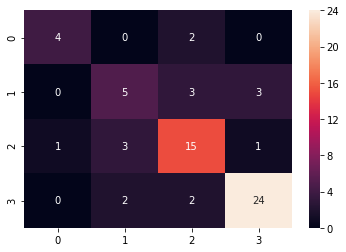

In [42]:
plot_confusion_matrix(y_pred, y_true)

In [43]:
from sklearn import metrics

In [45]:
metrics.accuracy_score(y_true, y_pred)

0.7384615384615385

In [49]:
metrics.f1_score(y_true, y_pred)

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [52]:
metrics.f1_score(y_true, y_pred, average=None)

array([0.72727273, 0.47619048, 0.71428571, 0.85714286])

In [48]:
metrics.recall_score(y_true, y_pred, average='weighted')

0.7384615384615385